# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [2]:
!nvidia-smi

Sun Apr  9 20:04:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:17:00.0 Off |                    0 |
|  0%   50C    P0    96W / 300W |      0MiB /  5067MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

### Data Augmentation
Training data variations are crated by data Augmentation.

In [115]:
# Transformations type : https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_train_1 = transforms.Compose([
    transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
    transforms.RandomRotation(10),     #Rotates the image to a specified angel
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
    transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])
 
transform_train_2 = transforms.Compose([
    #transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=[32,32], padding=4),
    transforms.RandomRotation(degrees=(-20, 20)),
    #transforms.RandomAdjustSharpness(sharpness_factor=2),
    #transforms.RandomResizedCrop(size=(32, 32)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])

In [116]:
transform_train = transform_train_2

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [117]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [118]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [119]:
# print test and train dataset properties
trainset, testset

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=4)
                RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

### Data Loader

In [120]:
BATCH_SIZE = 4
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

### Check data

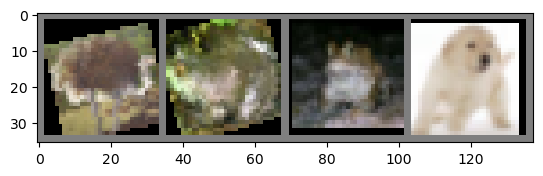

bird  frog  frog  dog  


In [121]:
# Code reused from Pytorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


In [122]:
# print size of data in batch

for d in trainloader:
    print(d[0].shape)
    break

torch.Size([4, 3, 32, 32])


## Model Architecture

Given below is a basic required architecture.


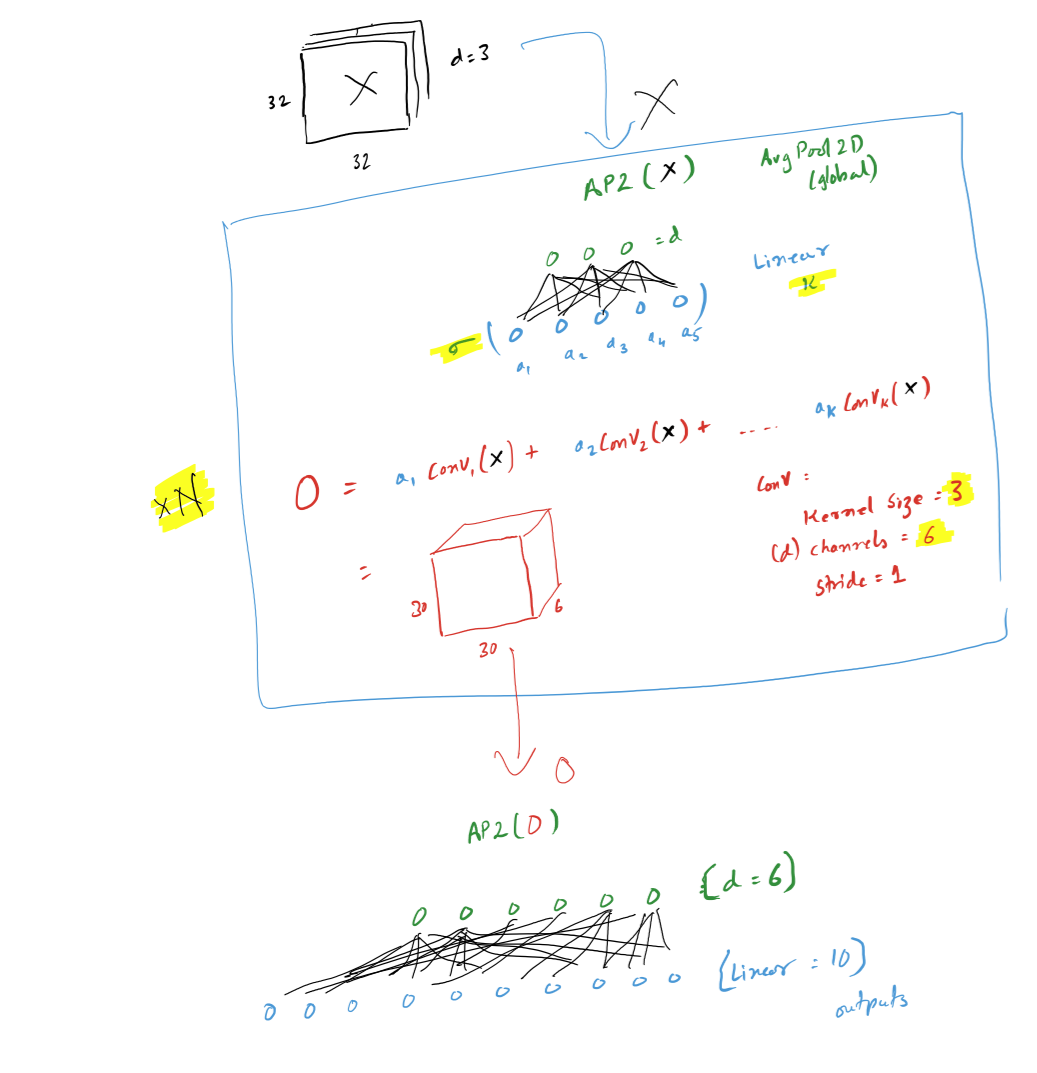

This architecture is further updated with additional parameters like dropouts, normalization etc to help aid in modeling.

In [123]:
# Parameters 

N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

In [124]:
class ConvBlock(nn.Sequential):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL):
        """
        Convolution Block.
        """
        
        super(ConvBlock, self).__init__(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            #nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout2d(p=0.1),
        )

In [125]:
class Backbone(nn.Module):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
        """
        Backbone Block, having K ConvBlocks returning weighted sum. weights calculated using linear transformation of adaptiveAvgPool (spatial average pool).
        """
            
        super(Backbone, self).__init__()

        # Boolean to print debug logs.
        self.debug = debug

        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.linear = nn.Sequential(
            nn.Linear(in_features=in_channels, out_features=k, bias=False),   # Question, can this be MLP?
            #nn.Tanh(),
            #nn.LeakyReLU(),
            # nn.Linear(in_features=k, out_features=k, bias=True),  
            #nn.ReLU(),
            nn.Sigmoid(),      # Non Linear Activation
            #nn.BatchNorm1d(k),
        )

        self.conv_blocks = nn.ModuleList([
            ConvBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
            for _ in range(k)
        ])

        self.batch_norm = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"{sap_out.shape=}")

        g_out = self.linear(sap_out)
        if self.debug: print(f"{g_out.shape=}")
        if self.debug: print(f"{g_out=}")

        outs = list()
        for a, conv_block in zip(g_out.transpose(0, 1), self.conv_blocks):
        #for conv2d in self.conv2ds:
            c_out = conv_block(x)
            if self.debug: print(f"{c_out.shape=}")
            if self.debug: print(f"{a.shape=}, \n{a=}")

            out = a.reshape(x.shape[0], 1, 1, 1)*c_out
            if self.debug: print(f"{out.shape=}")
            outs.append(out)
            #outs.append(c_out)

        out = sum(outs)
        if self.debug: print(f"{out.shape=}")

        out = self.batch_norm(out)
        if self.debug: print(f"batch_{out.shape=}")

        return out

In [134]:
class Classifier(nn.Module):
    
    def __init__(self, in_features, out_features, debug=True):
        """
        Classifer, to classify the CIFAR 10 dataset. it has SpatialAveragePool and an linear layer.
        """
        
        super(Classifier, self).__init__()
        self.debug = debug
        
        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.mlp = nn.Sequential(
            #nn.Linear(in_features=in_features, out_features=in_features * 2 // 3, bias=True),
            #nn.Dropout(p=0.1),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features * 2 // 3, out_features=in_features // 3, bias=True),
            #nn.Dropout(p=0.1),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features // 3, out_features=len(CLASSES), bias=True),
            nn.Linear(in_features=in_features, out_features=out_features, bias=True),
        )
        
    def forward(self, x):
        
        f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"Classifier: {f.shape=}")

        out = self.mlp(f)
        if self.debug: print(f"Classifier: {out.shape=}")

        return out

In [135]:
class Model(nn.Module):
    
    def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
        """
        Model, having N Backbones and a classifer.
        """
        super(Model, self).__init__()
        
        self.debug = debug   # Boolean to print debug logs.
        self.Ks = Ks
        self.channels = channels
        self.n = n

        self.backbones = nn.Sequential(*[
            Backbone(
                in_channels=self.channels[i], 
                out_channels=self.channels[i+1], 
                kernel_size=kernel_size, 
                k=self.Ks[i], 
                debug=debug
            ) 
            for i in range(self.n)
        ])
        
        self.classifier = Classifier(in_features=self.channels[-1], out_features=len(CLASSES), debug=debug)

    def set_debug(self, debug=True):
        
        self.debug = debug
        for backbone in self.backbones:
            backbone.debug = debug
        self.classifier.debug = debug

    def forward(self, x):
        x = self.backbones(x)
        out = self.classifier(x)
        return out

In [136]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, scheduler, trainloader, testloader, logs_per_epoch=4) -> None:
        """
        Trainer to help in training of the model.
        """
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        self.epochs = 0
        self.log_step = len(trainloader) // logs_per_epoch

        self.trainloader = trainloader
        self.testloader = testloader
        
        self.lrs = list()
        self.losses = list()
        self.val_losses = list()
        self.batch_losses = list()

        self.train_accuracy = list()
        self.val_accuracy = list()
        
    
    def train(self, epochs=3, use_gpu=False):
        
        for epoch in range(self.epochs, self.epochs + epochs):  # loop over the dataset multiple times

            batch_losses = list()
            running_loss = 0.0
            correct = 0
            total = 0
        
            
            # Set model to training.
            self.model.train()
            
            # Train loop
            for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch + 1} "):
                
                # Get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                
                # Transfer data to cuda.
                if use_gpu:
                    inputs = inputs.to('cuda')
                    labels = labels.to('cuda')

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Print statistics
                batch_losses.append(loss.item())
                running_loss += loss.item()
                if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                    avg_loss = running_loss / self.log_step
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                    running_loss = 0.0
                    self.batch_losses.append(avg_loss)

            self.losses.append(sum(batch_losses) / len(batch_losses))
            #print(f"Train Loss : {self.losses[-1]}")
            
            # Calculate accuracy
            accuracy = correct / total
            self.train_accuracy.append(accuracy)
            #print(f'Train Accuracy : {100 * accuracy:.2f} %')
            
            # Save Learning rate.
            #print(f"{self.scheduler.get_last_lr()=}")
            #print(f"{self.optimizer.param_groups[0]['lr']=}")
            self.lrs.append(self.optimizer.param_groups[0]['lr'])
            
            val_loss, val_accuracy = self.eval()
            self.scheduler.step(val_loss)
            
            print(f"Train Loss : {self.losses[-1]:.2f} | Train Accuracy : {100 * accuracy:.2f} | Test Loss : {val_loss:.2f} | Test Accuracy : {100 * val_accuracy:.2f}")

        self.epochs += epochs
        print('Finished Training')
    
    
    def eval(self):
        correct = 0
        total = 0
        losses = list()
        
        self.model.eval()
        
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                if USE_GPU:
                    images = images.to('cuda')
                    labels = labels.to('cuda')

                # calculate outputs by running images through the network
                outputs = self.model(images)

                loss = self.criterion(outputs, labels)
                losses.append(loss.item())

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        val_loss = sum(losses) / len(losses)
        self.val_losses.append(val_loss)

        #print(f"Val Loss : {val_loss}")

        accuracy = correct / total
        self.val_accuracy.append(accuracy)
        #print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
        
        return val_loss, accuracy
    
    def plot(self):
        fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
        fig.set_size_inches(15, 3)
        
        epochs_x = range(1, self.epochs+1)
        
        ax0.plot(epochs_x, self.lrs, label="LR", color='C3', lw=3, alpha=1)
        ax0.legend()
        ax0.set_yscale('log')
        ax0.set(title=f'Learning Rates', xlabel='Epoch', ylabel='Learning rate')

        X = np.linspace(1, len(self.losses), len(self.batch_losses))
        ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
        ax1.plot(epochs_x, self.losses, label='Train', color='C0', lw=3, alpha=1)
        ax1.plot(epochs_x, self.val_losses, label='Test', color='C1', lw=3, alpha=1)
        ax1.legend()
        ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
        
        ax2.plot(epochs_x, self.train_accuracy, label="Train", color='C0', lw=3, alpha=1)
        ax2.plot(epochs_x, self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
        ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        fig.show()
    

In [137]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [138]:
def model_summary(model, trainloader):
    """
    A wrapper method to help debug and understand the model paramters. 
    Importantly, it does one forward pass to calculate the image dimension when propogated to N Backbone.
    """
    img_sizes = list()
    
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            if USE_GPU:
                images = images.to('cuda')
                labels = labels.to('cuda')
            
            x = images
            
            img_sizes.append(x.shape[-1])
            for backbone in model.backbones:
                x = backbone(x)
                img_sizes.append(x.shape[-1])
            break
                
    print(f"{model.channels=}")
    print(f"{model.Ks=}")
    print(f"{model.n=}")
    print(f"{img_sizes=}")

## Experiment

In [139]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 3
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
channels = [IMG_CHANNELS, 64, 128, 256, 512, 1028] 
# Ks = channels[1:]
Ks = [3] * (len(channels) - 1)
N = len(channels) - 1
#
model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)

if USE_GPU: model.to('cuda')
model.set_debug(False)
model_summary(model=model, trainloader=trainloader)
model

model.channels=[3, 64, 128, 256, 512, 1028]
model.Ks=[3, 3, 3, 3, 3]
model.n=5
img_sizes=[32, 16, 8, 4, 2, 1]


Model(
  (backbones): Sequential(
    (0): Backbone(
      (spaitial_average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=False)
        (1): Sigmoid()
      )
      (conv_blocks): ModuleList(
        (0): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Dropout2d(p=0.1, inplace=False)
        )
        (1): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Dropout2d(p=0.1, inplace=Fals

In [143]:
# Init optimizer 

LR = 1e-3 #1e-3, 1e-4
LR_STEP_SIZE = 10
WEIGHT_DECAY = 0.05 # 0.15


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

constant_scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=20)
linear_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.3333333333333333, end_factor=1.0, total_iters=50, last_epoch=- 1, verbose=False)
polynomial_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=50, power=2.0, last_epoch=- 1, verbose=False)
exponential_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
cyclic_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-4, step_size_up=5, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=False, base_momentum=0.8, max_momentum=0.9, last_epoch=- 1, verbose=False)
one_cycle_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-5, total_steps=30, epochs=None, steps_per_epoch=None, pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=False, last_epoch=-1, verbose=False)
reduce_on_plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

sequential_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[polynomial_scheduler, cyclic_scheduler], milestones=[20])#, last_epoch=60)

scheduler = reduce_on_plateau_scheduler

optimizer.param_groups[0]['lr'] = LR

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 10, 10, 10, 10, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


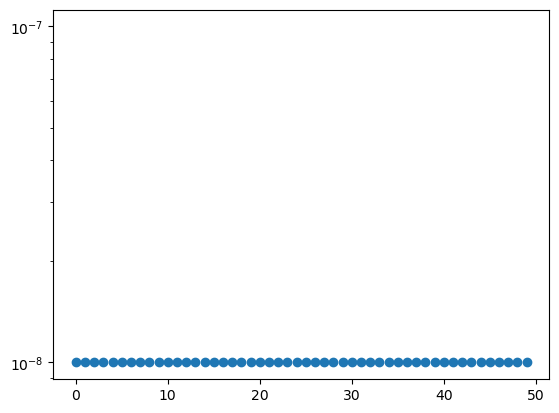

In [142]:
lrs_ = list()
values = list(range(10, 0, -1)) + list(range(0, 20)) + [10]*5 + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1))
print(values)
for i in range(50):
    optimizer.step()
    scheduler.step(values[i])
    #scheduler.step()
    #lrs_.append(scheduler.get_last_lr())
    lrs_.append(optimizer.param_groups[0]['lr'])
    
fig, ax = plt.subplots(1)
ax.scatter(range(len(lrs_)), lrs_)
ax.set_yscale('log')

In [144]:
# Init Trainer

BATCH_SIZE = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

Epoch 1 :   0%|          | 0/196 [00:00<?, ?it/s]

[1,    49] loss: 2.302
[1,    98] loss: 1.978
[1,   147] loss: 1.810
[1,   196] loss: 1.744
Train Loss : 1.96 | Train Accuracy : 29.11 | Test Loss : 1.64 | Test Accuracy : 39.01


Epoch 2 :   0%|          | 0/196 [00:00<?, ?it/s]

[2,    49] loss: 1.648
[2,    98] loss: 1.587
[2,   147] loss: 1.483
[2,   196] loss: 1.439
Train Loss : 1.54 | Train Accuracy : 44.09 | Test Loss : 1.40 | Test Accuracy : 49.11


Epoch 3 :   0%|          | 0/196 [00:00<?, ?it/s]

[3,    49] loss: 1.386
[3,    98] loss: 1.337
[3,   147] loss: 1.306
[3,   196] loss: 1.252
Train Loss : 1.32 | Train Accuracy : 52.96 | Test Loss : 1.21 | Test Accuracy : 56.18


Epoch 4 :   0%|          | 0/196 [00:00<?, ?it/s]

[4,    49] loss: 1.211
[4,    98] loss: 1.178
[4,   147] loss: 1.138
[4,   196] loss: 1.127
Train Loss : 1.16 | Train Accuracy : 58.73 | Test Loss : 1.09 | Test Accuracy : 64.90


Epoch 5 :   0%|          | 0/196 [00:00<?, ?it/s]

[5,    49] loss: 1.119
[5,    98] loss: 1.082
[5,   147] loss: 1.073
[5,   196] loss: 1.059
Train Loss : 1.08 | Train Accuracy : 62.20 | Test Loss : 0.99 | Test Accuracy : 67.01


Epoch 6 :   0%|          | 0/196 [00:00<?, ?it/s]

[6,    49] loss: 1.020
[6,    98] loss: 0.994
[6,   147] loss: 0.958
[6,   196] loss: 0.975
Train Loss : 0.99 | Train Accuracy : 65.43 | Test Loss : 0.90 | Test Accuracy : 70.39


Epoch 7 :   0%|          | 0/196 [00:00<?, ?it/s]

[7,    49] loss: 0.926
[7,    98] loss: 0.918
[7,   147] loss: 0.920
[7,   196] loss: 0.913
Train Loss : 0.92 | Train Accuracy : 67.92 | Test Loss : 0.81 | Test Accuracy : 73.71


Epoch 8 :   0%|          | 0/196 [00:00<?, ?it/s]

[8,    49] loss: 0.892
[8,    98] loss: 0.864
[8,   147] loss: 0.864
[8,   196] loss: 0.854
Train Loss : 0.87 | Train Accuracy : 69.88 | Test Loss : 0.78 | Test Accuracy : 74.95


Epoch 9 :   0%|          | 0/196 [00:00<?, ?it/s]

[9,    49] loss: 0.820
[9,    98] loss: 0.807
[9,   147] loss: 0.793
[9,   196] loss: 0.811
Train Loss : 0.81 | Train Accuracy : 71.86 | Test Loss : 0.70 | Test Accuracy : 76.18


Epoch 10 :   0%|          | 0/196 [00:00<?, ?it/s]

[10,    49] loss: 0.762
[10,    98] loss: 0.759
[10,   147] loss: 0.773
[10,   196] loss: 0.761
Train Loss : 0.76 | Train Accuracy : 73.64 | Test Loss : 0.74 | Test Accuracy : 78.19
Finished Training


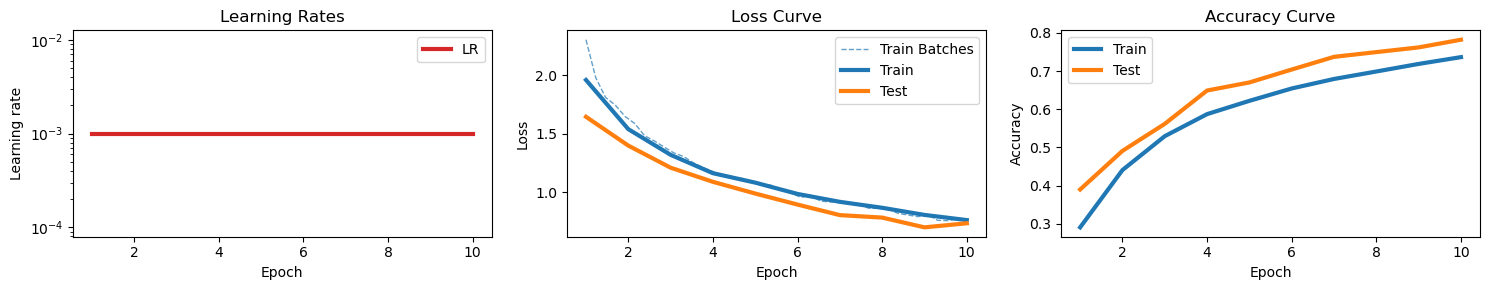

In [145]:
trainer.train(epochs=10, use_gpu=USE_GPU)
trainer.plot()

Epoch 11 :   0%|          | 0/196 [00:00<?, ?it/s]

[11,    49] loss: 0.732
[11,    98] loss: 0.720
[11,   147] loss: 0.731
[11,   196] loss: 0.702
Train Loss : 0.72 | Train Accuracy : 75.29 | Test Loss : 0.60 | Test Accuracy : 79.59


Epoch 12 :   0%|          | 0/196 [00:00<?, ?it/s]

[12,    49] loss: 0.678
[12,    98] loss: 0.693
[12,   147] loss: 0.684
[12,   196] loss: 0.701
Train Loss : 0.69 | Train Accuracy : 76.11 | Test Loss : 0.62 | Test Accuracy : 79.35


Epoch 13 :   0%|          | 0/196 [00:00<?, ?it/s]

[13,    49] loss: 0.702
[13,    98] loss: 0.672
[13,   147] loss: 0.656
[13,   196] loss: 0.650
Train Loss : 0.67 | Train Accuracy : 76.79 | Test Loss : 0.53 | Test Accuracy : 81.51


Epoch 14 :   0%|          | 0/196 [00:00<?, ?it/s]

[14,    49] loss: 0.620
[14,    98] loss: 0.620
[14,   147] loss: 0.641
[14,   196] loss: 0.635
Train Loss : 0.63 | Train Accuracy : 78.18 | Test Loss : 0.51 | Test Accuracy : 82.55


Epoch 15 :   0%|          | 0/196 [00:00<?, ?it/s]

[15,    49] loss: 0.615
[15,    98] loss: 0.602
[15,   147] loss: 0.583
[15,   196] loss: 0.614
Train Loss : 0.60 | Train Accuracy : 79.04 | Test Loss : 0.49 | Test Accuracy : 83.23


Epoch 16 :   0%|          | 0/196 [00:00<?, ?it/s]

[16,    49] loss: 0.556
[16,    98] loss: 0.575
[16,   147] loss: 0.575
[16,   196] loss: 0.589
Train Loss : 0.57 | Train Accuracy : 80.27 | Test Loss : 0.48 | Test Accuracy : 84.00


Epoch 17 :   0%|          | 0/196 [00:00<?, ?it/s]

[17,    49] loss: 0.547
[17,    98] loss: 0.552
[17,   147] loss: 0.537
[17,   196] loss: 0.572
Train Loss : 0.55 | Train Accuracy : 80.59 | Test Loss : 0.47 | Test Accuracy : 84.32


Epoch 18 :   0%|          | 0/196 [00:00<?, ?it/s]

[18,    49] loss: 0.529
[18,    98] loss: 0.541
[18,   147] loss: 0.543
[18,   196] loss: 0.523
Train Loss : 0.53 | Train Accuracy : 81.17 | Test Loss : 0.48 | Test Accuracy : 83.59


Epoch 19 :   0%|          | 0/196 [00:00<?, ?it/s]

[19,    49] loss: 0.521
[19,    98] loss: 0.520
[19,   147] loss: 0.504
[19,   196] loss: 0.508
Train Loss : 0.51 | Train Accuracy : 82.03 | Test Loss : 0.46 | Test Accuracy : 84.55


Epoch 20 :   0%|          | 0/196 [00:00<?, ?it/s]

[20,    49] loss: 0.497
[20,    98] loss: 0.493
[20,   147] loss: 0.489
[20,   196] loss: 0.513
Train Loss : 0.50 | Train Accuracy : 82.45 | Test Loss : 0.45 | Test Accuracy : 84.82


Epoch 21 :   0%|          | 0/196 [00:00<?, ?it/s]

[21,    49] loss: 0.479
[21,    98] loss: 0.473
[21,   147] loss: 0.479
[21,   196] loss: 0.497
Train Loss : 0.48 | Train Accuracy : 83.38 | Test Loss : 0.43 | Test Accuracy : 85.78


Epoch 22 :   0%|          | 0/196 [00:00<?, ?it/s]

[22,    49] loss: 0.452
[22,    98] loss: 0.471
[22,   147] loss: 0.466
[22,   196] loss: 0.465
Train Loss : 0.46 | Train Accuracy : 83.69 | Test Loss : 0.42 | Test Accuracy : 85.69


Epoch 23 :   0%|          | 0/196 [00:00<?, ?it/s]

[23,    49] loss: 0.437
[23,    98] loss: 0.442
[23,   147] loss: 0.457
[23,   196] loss: 0.453
Train Loss : 0.45 | Train Accuracy : 84.19 | Test Loss : 0.42 | Test Accuracy : 85.96


Epoch 24 :   0%|          | 0/196 [00:00<?, ?it/s]

[24,    49] loss: 0.423
[24,    98] loss: 0.445
[24,   147] loss: 0.436
[24,   196] loss: 0.447
Train Loss : 0.44 | Train Accuracy : 84.71 | Test Loss : 0.42 | Test Accuracy : 85.89


Epoch 25 :   0%|          | 0/196 [00:00<?, ?it/s]

[25,    49] loss: 0.414
[25,    98] loss: 0.421
[25,   147] loss: 0.411
[25,   196] loss: 0.445
Train Loss : 0.42 | Train Accuracy : 85.16 | Test Loss : 0.40 | Test Accuracy : 86.24


Epoch 26 :   0%|          | 0/196 [00:00<?, ?it/s]

[26,    49] loss: 0.398
[26,    98] loss: 0.405
[26,   147] loss: 0.409
[26,   196] loss: 0.425
Train Loss : 0.41 | Train Accuracy : 85.54 | Test Loss : 0.39 | Test Accuracy : 86.79


Epoch 27 :   0%|          | 0/196 [00:00<?, ?it/s]

[27,    49] loss: 0.379
[27,    98] loss: 0.385
[27,   147] loss: 0.394
[27,   196] loss: 0.396
Train Loss : 0.39 | Train Accuracy : 86.32 | Test Loss : 0.40 | Test Accuracy : 86.66


Epoch 28 :   0%|          | 0/196 [00:00<?, ?it/s]

[28,    49] loss: 0.376
[28,    98] loss: 0.364
[28,   147] loss: 0.389
[28,   196] loss: 0.386
Train Loss : 0.38 | Train Accuracy : 86.71 | Test Loss : 0.41 | Test Accuracy : 86.46


Epoch 29 :   0%|          | 0/196 [00:00<?, ?it/s]

[29,    49] loss: 0.359
[29,    98] loss: 0.368
[29,   147] loss: 0.376
[29,   196] loss: 0.367
Train Loss : 0.37 | Train Accuracy : 87.10 | Test Loss : 0.42 | Test Accuracy : 86.46


Epoch 30 :   0%|          | 0/196 [00:00<?, ?it/s]

[30,    49] loss: 0.365
[30,    98] loss: 0.364
[30,   147] loss: 0.359
[30,   196] loss: 0.370
Train Loss : 0.36 | Train Accuracy : 87.18 | Test Loss : 0.41 | Test Accuracy : 86.68
Finished Training


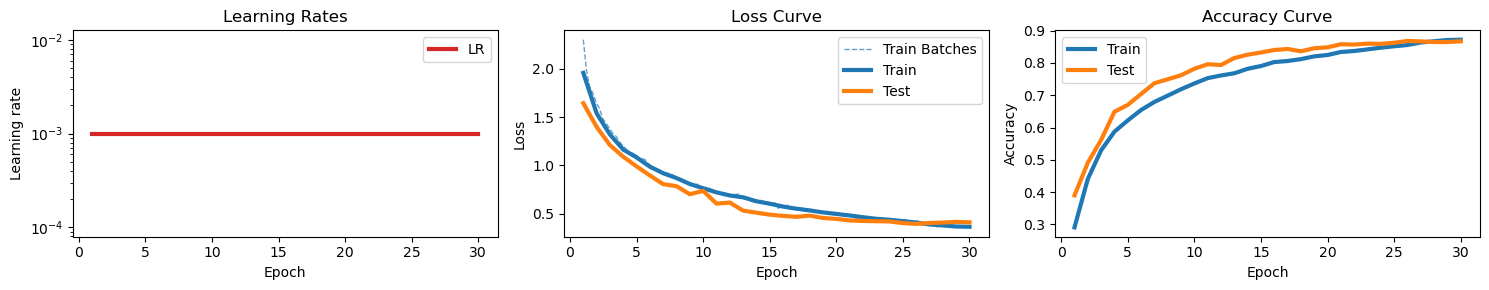

In [146]:
trainer.train(epochs=20, use_gpu=USE_GPU)
trainer.plot()

Epoch 31 :   0%|          | 0/196 [00:00<?, ?it/s]

[31,    49] loss: 0.327
[31,    98] loss: 0.291
[31,   147] loss: 0.282
[31,   196] loss: 0.277
Train Loss : 0.29 | Train Accuracy : 89.72 | Test Loss : 0.36 | Test Accuracy : 88.50


Epoch 32 :   0%|          | 0/196 [00:00<?, ?it/s]

[32,    49] loss: 0.259
[32,    98] loss: 0.269
[32,   147] loss: 0.258
[32,   196] loss: 0.272
Train Loss : 0.26 | Train Accuracy : 90.61 | Test Loss : 0.36 | Test Accuracy : 88.62


Epoch 33 :   0%|          | 0/196 [00:00<?, ?it/s]

[33,    49] loss: 0.258
[33,    98] loss: 0.270
[33,   147] loss: 0.250
[33,   196] loss: 0.254
Train Loss : 0.26 | Train Accuracy : 90.90 | Test Loss : 0.35 | Test Accuracy : 88.90


Epoch 34 :   0%|          | 0/196 [00:00<?, ?it/s]

[34,    49] loss: 0.251
[34,    98] loss: 0.251
[34,   147] loss: 0.252
[34,   196] loss: 0.254
Train Loss : 0.25 | Train Accuracy : 91.21 | Test Loss : 0.36 | Test Accuracy : 88.92


Epoch 35 :   0%|          | 0/196 [00:00<?, ?it/s]

[35,    49] loss: 0.234
[35,    98] loss: 0.234
[35,   147] loss: 0.244
[35,   196] loss: 0.233
Train Loss : 0.24 | Train Accuracy : 91.68 | Test Loss : 0.35 | Test Accuracy : 88.98


Epoch 36 :   0%|          | 0/196 [00:00<?, ?it/s]

[36,    49] loss: 0.239
[36,    98] loss: 0.225
[36,   147] loss: 0.239
[36,   196] loss: 0.227
Train Loss : 0.23 | Train Accuracy : 91.84 | Test Loss : 0.35 | Test Accuracy : 89.05


Epoch 37 :   0%|          | 0/196 [00:00<?, ?it/s]

[37,    49] loss: 0.234
[37,    98] loss: 0.223
[37,   147] loss: 0.231
[37,   196] loss: 0.235
Train Loss : 0.23 | Train Accuracy : 91.90 | Test Loss : 0.35 | Test Accuracy : 89.18


Epoch 38 :   0%|          | 0/196 [00:00<?, ?it/s]

[38,    49] loss: 0.217
[38,    98] loss: 0.225
[38,   147] loss: 0.237
[38,   196] loss: 0.218
Train Loss : 0.22 | Train Accuracy : 92.16 | Test Loss : 0.35 | Test Accuracy : 89.20


Epoch 39 :   0%|          | 0/196 [00:00<?, ?it/s]

[39,    49] loss: 0.219
[39,    98] loss: 0.222
[39,   147] loss: 0.216
[39,   196] loss: 0.222
Train Loss : 0.22 | Train Accuracy : 92.34 | Test Loss : 0.35 | Test Accuracy : 89.20


Epoch 40 :   0%|          | 0/196 [00:00<?, ?it/s]

[40,    49] loss: 0.211
[40,    98] loss: 0.221
[40,   147] loss: 0.215
[40,   196] loss: 0.213
Train Loss : 0.21 | Train Accuracy : 92.36 | Test Loss : 0.35 | Test Accuracy : 89.18


Epoch 41 :   0%|          | 0/196 [00:00<?, ?it/s]

[41,    49] loss: 0.208
[41,    98] loss: 0.215
[41,   147] loss: 0.205
[41,   196] loss: 0.218
Train Loss : 0.21 | Train Accuracy : 92.65 | Test Loss : 0.35 | Test Accuracy : 89.20


Epoch 42 :   0%|          | 0/196 [00:00<?, ?it/s]

[42,    49] loss: 0.212
[42,    98] loss: 0.207
[42,   147] loss: 0.211
[42,   196] loss: 0.206
Train Loss : 0.21 | Train Accuracy : 92.81 | Test Loss : 0.35 | Test Accuracy : 89.40


Epoch 43 :   0%|          | 0/196 [00:00<?, ?it/s]

[43,    49] loss: 0.210
[43,    98] loss: 0.210
[43,   147] loss: 0.198
[43,   196] loss: 0.211
Train Loss : 0.21 | Train Accuracy : 92.74 | Test Loss : 0.35 | Test Accuracy : 89.18


Epoch 44 :   0%|          | 0/196 [00:00<?, ?it/s]

[44,    49] loss: 0.199
[44,    98] loss: 0.200
[44,   147] loss: 0.202
[44,   196] loss: 0.204
Train Loss : 0.20 | Train Accuracy : 92.94 | Test Loss : 0.35 | Test Accuracy : 89.37


Epoch 45 :   0%|          | 0/196 [00:00<?, ?it/s]

[45,    49] loss: 0.188
[45,    98] loss: 0.186
[45,   147] loss: 0.201
[45,   196] loss: 0.202
Train Loss : 0.19 | Train Accuracy : 93.15 | Test Loss : 0.35 | Test Accuracy : 89.23


Epoch 46 :   0%|          | 0/196 [00:00<?, ?it/s]

[46,    49] loss: 0.189
[46,    98] loss: 0.187
[46,   147] loss: 0.191
[46,   196] loss: 0.198
Train Loss : 0.19 | Train Accuracy : 93.28 | Test Loss : 0.35 | Test Accuracy : 89.46


Epoch 47 :   0%|          | 0/196 [00:00<?, ?it/s]

[47,    49] loss: 0.180
[47,    98] loss: 0.193
[47,   147] loss: 0.180
[47,   196] loss: 0.186
Train Loss : 0.18 | Train Accuracy : 93.50 | Test Loss : 0.35 | Test Accuracy : 89.54


Epoch 48 :   0%|          | 0/196 [00:00<?, ?it/s]

[48,    49] loss: 0.183
[48,    98] loss: 0.189
[48,   147] loss: 0.181
[48,   196] loss: 0.179
Train Loss : 0.18 | Train Accuracy : 93.54 | Test Loss : 0.35 | Test Accuracy : 89.50


Epoch 49 :   0%|          | 0/196 [00:00<?, ?it/s]

[49,    49] loss: 0.187
[49,    98] loss: 0.187
[49,   147] loss: 0.185
[49,   196] loss: 0.189
Train Loss : 0.19 | Train Accuracy : 93.36 | Test Loss : 0.35 | Test Accuracy : 89.52


Epoch 50 :   0%|          | 0/196 [00:00<?, ?it/s]

[50,    49] loss: 0.182
[50,    98] loss: 0.180
[50,   147] loss: 0.183
[50,   196] loss: 0.180
Train Loss : 0.18 | Train Accuracy : 93.66 | Test Loss : 0.35 | Test Accuracy : 89.71
Finished Training


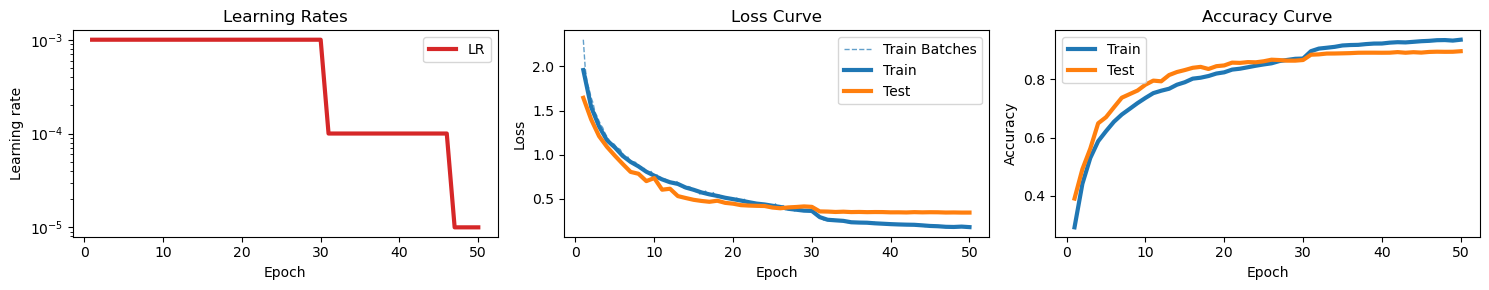

In [147]:
trainer.train(epochs=20, use_gpu=USE_GPU)
trainer.plot()

Epoch 51 :   0%|          | 0/196 [00:00<?, ?it/s]

[51,    49] loss: 0.178
[51,    98] loss: 0.170
[51,   147] loss: 0.188
[51,   196] loss: 0.176
Train Loss : 0.18 | Train Accuracy : 93.71 | Test Loss : 0.34 | Test Accuracy : 89.55


Epoch 52 :   0%|          | 0/196 [00:00<?, ?it/s]

[52,    49] loss: 0.172
[52,    98] loss: 0.185
[52,   147] loss: 0.180
[52,   196] loss: 0.176
Train Loss : 0.18 | Train Accuracy : 93.70 | Test Loss : 0.35 | Test Accuracy : 89.58


Epoch 53 :   0%|          | 0/196 [00:00<?, ?it/s]

[53,    49] loss: 0.178
[53,    98] loss: 0.181
[53,   147] loss: 0.179
[53,   196] loss: 0.175
Train Loss : 0.18 | Train Accuracy : 93.61 | Test Loss : 0.35 | Test Accuracy : 89.62


Epoch 54 :   0%|          | 0/196 [00:00<?, ?it/s]

[54,    49] loss: 0.177
[54,    98] loss: 0.181
[54,   147] loss: 0.182
[54,   196] loss: 0.166
Train Loss : 0.18 | Train Accuracy : 93.80 | Test Loss : 0.35 | Test Accuracy : 89.57


Epoch 55 :   0%|          | 0/196 [00:00<?, ?it/s]

[55,    49] loss: 0.174
[55,    98] loss: 0.182
[55,   147] loss: 0.183
[55,   196] loss: 0.187
Train Loss : 0.18 | Train Accuracy : 93.60 | Test Loss : 0.35 | Test Accuracy : 89.59


Epoch 56 :   0%|          | 0/196 [00:00<?, ?it/s]

[56,    49] loss: 0.176
[56,    98] loss: 0.178
[56,   147] loss: 0.182
[56,   196] loss: 0.176
Train Loss : 0.18 | Train Accuracy : 93.83 | Test Loss : 0.34 | Test Accuracy : 89.76


Epoch 57 :   0%|          | 0/196 [00:00<?, ?it/s]

[57,    49] loss: 0.177
[57,    98] loss: 0.180
[57,   147] loss: 0.168
[57,   196] loss: 0.172
Train Loss : 0.17 | Train Accuracy : 93.90 | Test Loss : 0.35 | Test Accuracy : 89.63


Epoch 58 :   0%|          | 0/196 [00:00<?, ?it/s]

[58,    49] loss: 0.179
[58,    98] loss: 0.172
[58,   147] loss: 0.186
[58,   196] loss: 0.178
Train Loss : 0.18 | Train Accuracy : 93.81 | Test Loss : 0.34 | Test Accuracy : 89.67


Epoch 59 :   0%|          | 0/196 [00:00<?, ?it/s]

[59,    49] loss: 0.176
[59,    98] loss: 0.176
[59,   147] loss: 0.176
[59,   196] loss: 0.174
Train Loss : 0.18 | Train Accuracy : 93.88 | Test Loss : 0.35 | Test Accuracy : 89.62


Epoch 60 :   0%|          | 0/196 [00:00<?, ?it/s]

[60,    49] loss: 0.177
[60,    98] loss: 0.176
[60,   147] loss: 0.176
[60,   196] loss: 0.176
Train Loss : 0.18 | Train Accuracy : 93.79 | Test Loss : 0.35 | Test Accuracy : 89.61
Finished Training


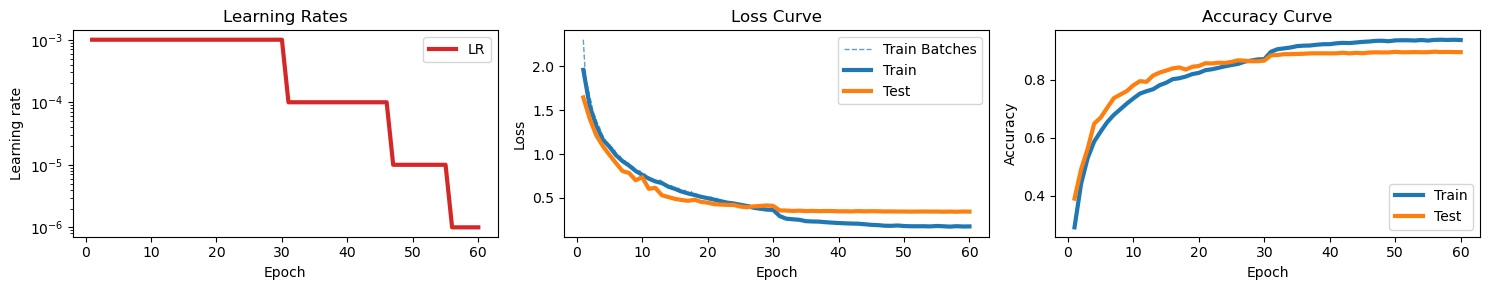

In [148]:
trainer.train(epochs=10, use_gpu=USE_GPU)
trainer.plot()

Epoch 61 :   0%|          | 0/196 [00:00<?, ?it/s]

[61,    49] loss: 0.169
[61,    98] loss: 0.185
[61,   147] loss: 0.183
[61,   196] loss: 0.176
Train Loss : 0.18 | Train Accuracy : 93.61 | Test Loss : 0.35 | Test Accuracy : 89.67


Epoch 62 :   0%|          | 0/196 [00:00<?, ?it/s]

[62,    49] loss: 0.178
[62,    98] loss: 0.178
[62,   147] loss: 0.176
[62,   196] loss: 0.178
Train Loss : 0.18 | Train Accuracy : 93.71 | Test Loss : 0.34 | Test Accuracy : 89.61


Epoch 63 :   0%|          | 0/196 [00:00<?, ?it/s]

[63,    49] loss: 0.174
[63,    98] loss: 0.177
[63,   147] loss: 0.183
[63,   196] loss: 0.173
Train Loss : 0.18 | Train Accuracy : 93.70 | Test Loss : 0.34 | Test Accuracy : 89.70


Epoch 64 :   0%|          | 0/196 [00:00<?, ?it/s]

[64,    49] loss: 0.179
[64,    98] loss: 0.181
[64,   147] loss: 0.181
[64,   196] loss: 0.170
Train Loss : 0.18 | Train Accuracy : 93.75 | Test Loss : 0.34 | Test Accuracy : 89.69


Epoch 65 :   0%|          | 0/196 [00:00<?, ?it/s]

[65,    49] loss: 0.173
[65,    98] loss: 0.180
[65,   147] loss: 0.177
[65,   196] loss: 0.177
Train Loss : 0.18 | Train Accuracy : 93.82 | Test Loss : 0.34 | Test Accuracy : 89.72


Epoch 66 :   0%|          | 0/196 [00:00<?, ?it/s]

[66,    49] loss: 0.182
[66,    98] loss: 0.182
[66,   147] loss: 0.180
[66,   196] loss: 0.179
Train Loss : 0.18 | Train Accuracy : 93.71 | Test Loss : 0.35 | Test Accuracy : 89.73


Epoch 67 :   0%|          | 0/196 [00:00<?, ?it/s]

[67,    49] loss: 0.174
[67,    98] loss: 0.177
[67,   147] loss: 0.174
[67,   196] loss: 0.175
Train Loss : 0.18 | Train Accuracy : 93.82 | Test Loss : 0.34 | Test Accuracy : 89.73


Epoch 68 :   0%|          | 0/196 [00:00<?, ?it/s]

[68,    49] loss: 0.182
[68,    98] loss: 0.175
[68,   147] loss: 0.176
[68,   196] loss: 0.178
Train Loss : 0.18 | Train Accuracy : 93.72 | Test Loss : 0.34 | Test Accuracy : 89.62


Epoch 69 :   0%|          | 0/196 [00:00<?, ?it/s]

[69,    49] loss: 0.177
[69,    98] loss: 0.181
[69,   147] loss: 0.184
[69,   196] loss: 0.173
Train Loss : 0.18 | Train Accuracy : 93.78 | Test Loss : 0.34 | Test Accuracy : 89.67


Epoch 70 :   0%|          | 0/196 [00:00<?, ?it/s]

[70,    49] loss: 0.180
[70,    98] loss: 0.173
[70,   147] loss: 0.179
[70,   196] loss: 0.172
Train Loss : 0.18 | Train Accuracy : 93.89 | Test Loss : 0.34 | Test Accuracy : 89.59
Finished Training


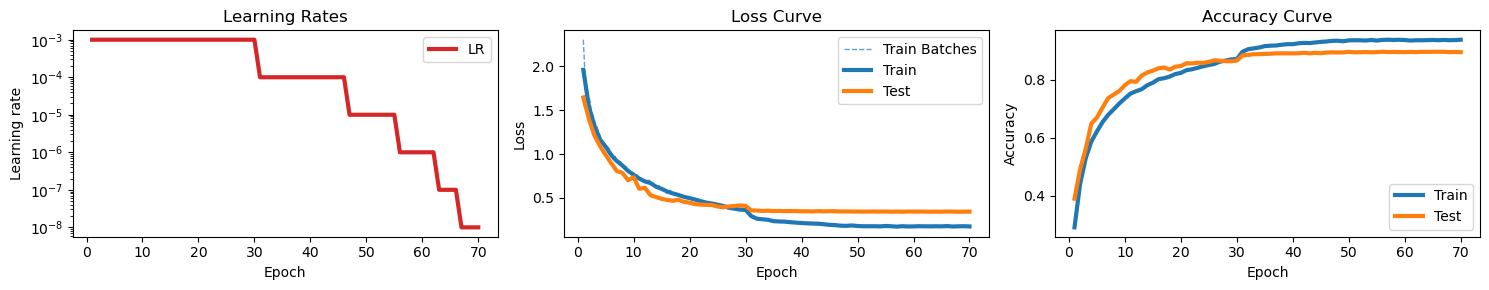

In [149]:
trainer.train(epochs=10, use_gpu=USE_GPU)
trainer.plot()

Epoch 63 :   0%|          | 0/196 [00:00<?, ?it/s]

[63,    49] loss: 0.253
[63,    98] loss: 0.254
[63,   147] loss: 0.244
[63,   196] loss: 0.251
Train Loss : 0.25 | Train Accuracy : 91.15 | Test Loss : 0.32 | Test Accuracy : 89.46


Epoch 64 :   0%|          | 0/196 [00:00<?, ?it/s]

[64,    49] loss: 0.251
[64,    98] loss: 0.257
[64,   147] loss: 0.256
[64,   196] loss: 0.250
Train Loss : 0.25 | Train Accuracy : 90.96 | Test Loss : 0.32 | Test Accuracy : 89.44


Epoch 65 :   0%|          | 0/196 [00:00<?, ?it/s]

[65,    49] loss: 0.247
[65,    98] loss: 0.255
[65,   147] loss: 0.248
[65,   196] loss: 0.249
Train Loss : 0.25 | Train Accuracy : 91.25 | Test Loss : 0.32 | Test Accuracy : 89.46


Epoch 66 :   0%|          | 0/196 [00:00<?, ?it/s]

[66,    49] loss: 0.249
[66,    98] loss: 0.256
[66,   147] loss: 0.255
[66,   196] loss: 0.254
Train Loss : 0.25 | Train Accuracy : 91.04 | Test Loss : 0.32 | Test Accuracy : 89.55


Epoch 67 :   0%|          | 0/196 [00:00<?, ?it/s]

[67,    49] loss: 0.253
[67,    98] loss: 0.255
[67,   147] loss: 0.255
[67,   196] loss: 0.260
Train Loss : 0.26 | Train Accuracy : 90.92 | Test Loss : 0.32 | Test Accuracy : 89.57


Epoch 68 :   0%|          | 0/196 [00:00<?, ?it/s]

[68,    49] loss: 0.261
[68,    98] loss: 0.257
[68,   147] loss: 0.251
[68,   196] loss: 0.240
Train Loss : 0.25 | Train Accuracy : 91.05 | Test Loss : 0.32 | Test Accuracy : 89.48


Epoch 69 :   0%|          | 0/196 [00:00<?, ?it/s]

[69,    49] loss: 0.254
[69,    98] loss: 0.245
[69,   147] loss: 0.252
[69,   196] loss: 0.257
Train Loss : 0.25 | Train Accuracy : 91.19 | Test Loss : 0.32 | Test Accuracy : 89.53


Epoch 70 :   0%|          | 0/196 [00:00<?, ?it/s]

[70,    49] loss: 0.254
[70,    98] loss: 0.247
[70,   147] loss: 0.254
[70,   196] loss: 0.257
Train Loss : 0.25 | Train Accuracy : 91.17 | Test Loss : 0.32 | Test Accuracy : 89.39


Epoch 71 :   0%|          | 0/196 [00:00<?, ?it/s]

[71,    49] loss: 0.251
[71,    98] loss: 0.248
[71,   147] loss: 0.255
[71,   196] loss: 0.254
Train Loss : 0.25 | Train Accuracy : 91.07 | Test Loss : 0.32 | Test Accuracy : 89.34


Epoch 72 :   0%|          | 0/196 [00:00<?, ?it/s]

[72,    49] loss: 0.259
[72,    98] loss: 0.253
[72,   147] loss: 0.252
[72,   196] loss: 0.243
Train Loss : 0.25 | Train Accuracy : 91.17 | Test Loss : 0.32 | Test Accuracy : 89.50


Epoch 73 :   0%|          | 0/196 [00:00<?, ?it/s]

[73,    49] loss: 0.261
[73,    98] loss: 0.250
[73,   147] loss: 0.256
[73,   196] loss: 0.257
Train Loss : 0.26 | Train Accuracy : 91.03 | Test Loss : 0.32 | Test Accuracy : 89.50


Epoch 74 :   0%|          | 0/196 [00:00<?, ?it/s]

[74,    49] loss: 0.241
[74,    98] loss: 0.254
[74,   147] loss: 0.259
[74,   196] loss: 0.251
Train Loss : 0.25 | Train Accuracy : 91.22 | Test Loss : 0.32 | Test Accuracy : 89.36


Epoch 75 :   0%|          | 0/196 [00:00<?, ?it/s]

[75,    49] loss: 0.251
[75,    98] loss: 0.257
[75,   147] loss: 0.252
[75,   196] loss: 0.259
Train Loss : 0.25 | Train Accuracy : 90.92 | Test Loss : 0.32 | Test Accuracy : 89.42


Epoch 76 :   0%|          | 0/196 [00:00<?, ?it/s]

[76,    49] loss: 0.253
[76,    98] loss: 0.260
[76,   147] loss: 0.245
[76,   196] loss: 0.251
Train Loss : 0.25 | Train Accuracy : 91.15 | Test Loss : 0.32 | Test Accuracy : 89.52


Epoch 77 :   0%|          | 0/196 [00:00<?, ?it/s]

[77,    49] loss: 0.253
[77,    98] loss: 0.243
[77,   147] loss: 0.249
[77,   196] loss: 0.251
Train Loss : 0.25 | Train Accuracy : 91.28 | Test Loss : 0.32 | Test Accuracy : 89.53


Epoch 78 :   0%|          | 0/196 [00:00<?, ?it/s]

[78,    49] loss: 0.254
[78,    98] loss: 0.259
[78,   147] loss: 0.248
[78,   196] loss: 0.248
Train Loss : 0.25 | Train Accuracy : 91.09 | Test Loss : 0.32 | Test Accuracy : 89.44


Epoch 79 :   0%|          | 0/196 [00:00<?, ?it/s]

[79,    49] loss: 0.250
[79,    98] loss: 0.255
[79,   147] loss: 0.251
[79,   196] loss: 0.256
Train Loss : 0.25 | Train Accuracy : 91.04 | Test Loss : 0.32 | Test Accuracy : 89.59


Epoch 80 :   0%|          | 0/196 [00:00<?, ?it/s]

[80,    49] loss: 0.252
[80,    98] loss: 0.250
[80,   147] loss: 0.258
[80,   196] loss: 0.246
Train Loss : 0.25 | Train Accuracy : 91.05 | Test Loss : 0.32 | Test Accuracy : 89.42


Epoch 81 :   0%|          | 0/196 [00:00<?, ?it/s]

[81,    49] loss: 0.251
[81,    98] loss: 0.244
[81,   147] loss: 0.253
[81,   196] loss: 0.256
Train Loss : 0.25 | Train Accuracy : 91.10 | Test Loss : 0.32 | Test Accuracy : 89.44


Epoch 82 :   0%|          | 0/196 [00:00<?, ?it/s]

[82,    49] loss: 0.248
[82,    98] loss: 0.250
[82,   147] loss: 0.255
[82,   196] loss: 0.241
Train Loss : 0.25 | Train Accuracy : 91.22 | Test Loss : 0.32 | Test Accuracy : 89.52


Epoch 83 :   0%|          | 0/196 [00:00<?, ?it/s]

[83,    49] loss: 0.256
[83,    98] loss: 0.250
[83,   147] loss: 0.257
[83,   196] loss: 0.266
Train Loss : 0.26 | Train Accuracy : 91.00 | Test Loss : 0.32 | Test Accuracy : 89.46


Epoch 84 :   0%|          | 0/196 [00:00<?, ?it/s]

[84,    49] loss: 0.253
[84,    98] loss: 0.250
[84,   147] loss: 0.255
[84,   196] loss: 0.243
Train Loss : 0.25 | Train Accuracy : 91.17 | Test Loss : 0.32 | Test Accuracy : 89.46


Epoch 85 :   0%|          | 0/196 [00:00<?, ?it/s]

[85,    49] loss: 0.252
[85,    98] loss: 0.246
[85,   147] loss: 0.243
[85,   196] loss: 0.257
Train Loss : 0.25 | Train Accuracy : 91.25 | Test Loss : 0.32 | Test Accuracy : 89.49


Epoch 86 :   0%|          | 0/196 [00:00<?, ?it/s]

[86,    49] loss: 0.243
[86,    98] loss: 0.247
[86,   147] loss: 0.259
[86,   196] loss: 0.255
Train Loss : 0.25 | Train Accuracy : 91.07 | Test Loss : 0.32 | Test Accuracy : 89.54


Epoch 87 :   0%|          | 0/196 [00:00<?, ?it/s]

[87,    49] loss: 0.261
[87,    98] loss: 0.260
[87,   147] loss: 0.243
[87,   196] loss: 0.241
Train Loss : 0.25 | Train Accuracy : 91.10 | Test Loss : 0.32 | Test Accuracy : 89.44


Epoch 88 :   0%|          | 0/196 [00:00<?, ?it/s]

[88,    49] loss: 0.257
[88,    98] loss: 0.256
[88,   147] loss: 0.249
[88,   196] loss: 0.251
Train Loss : 0.25 | Train Accuracy : 91.08 | Test Loss : 0.32 | Test Accuracy : 89.48


Epoch 89 :   0%|          | 0/196 [00:00<?, ?it/s]

[89,    49] loss: 0.252
[89,    98] loss: 0.257
[89,   147] loss: 0.255
[89,   196] loss: 0.251
Train Loss : 0.25 | Train Accuracy : 91.07 | Test Loss : 0.32 | Test Accuracy : 89.42


Epoch 90 :   0%|          | 0/196 [00:00<?, ?it/s]

[90,    49] loss: 0.239
[90,    98] loss: 0.246
[90,   147] loss: 0.256
[90,   196] loss: 0.244
Train Loss : 0.25 | Train Accuracy : 91.26 | Test Loss : 0.32 | Test Accuracy : 89.50


Epoch 91 :   0%|          | 0/196 [00:00<?, ?it/s]

[91,    49] loss: 0.253
[91,    98] loss: 0.260
[91,   147] loss: 0.262
[91,   196] loss: 0.257
Train Loss : 0.26 | Train Accuracy : 91.08 | Test Loss : 0.32 | Test Accuracy : 89.57


Epoch 92 :   0%|          | 0/196 [00:00<?, ?it/s]

[92,    49] loss: 0.257
[92,    98] loss: 0.237
[92,   147] loss: 0.253
[92,   196] loss: 0.255
Train Loss : 0.25 | Train Accuracy : 91.15 | Test Loss : 0.32 | Test Accuracy : 89.41


Epoch 93 :   0%|          | 0/196 [00:00<?, ?it/s]

[93,    49] loss: 0.251
[93,    98] loss: 0.254
[93,   147] loss: 0.250
[93,   196] loss: 0.254
Train Loss : 0.25 | Train Accuracy : 91.16 | Test Loss : 0.32 | Test Accuracy : 89.50


Epoch 94 :   0%|          | 0/196 [00:00<?, ?it/s]

[94,    49] loss: 0.246
[94,    98] loss: 0.257
[94,   147] loss: 0.258
[94,   196] loss: 0.253
Train Loss : 0.25 | Train Accuracy : 91.00 | Test Loss : 0.32 | Test Accuracy : 89.49


Epoch 95 :   0%|          | 0/196 [00:00<?, ?it/s]

[95,    49] loss: 0.251
[95,    98] loss: 0.257
[95,   147] loss: 0.245
[95,   196] loss: 0.251
Train Loss : 0.25 | Train Accuracy : 91.17 | Test Loss : 0.32 | Test Accuracy : 89.47


Epoch 96 :   0%|          | 0/196 [00:00<?, ?it/s]

[96,    49] loss: 0.249
[96,    98] loss: 0.254
[96,   147] loss: 0.249
[96,   196] loss: 0.250
Train Loss : 0.25 | Train Accuracy : 91.19 | Test Loss : 0.32 | Test Accuracy : 89.43


Epoch 97 :   0%|          | 0/196 [00:00<?, ?it/s]

[97,    49] loss: 0.254
[97,    98] loss: 0.248
[97,   147] loss: 0.256
[97,   196] loss: 0.256
Train Loss : 0.25 | Train Accuracy : 91.12 | Test Loss : 0.32 | Test Accuracy : 89.47


Epoch 98 :   0%|          | 0/196 [00:00<?, ?it/s]

[98,    49] loss: 0.251
[98,    98] loss: 0.252
[98,   147] loss: 0.247
[98,   196] loss: 0.249
Train Loss : 0.25 | Train Accuracy : 91.24 | Test Loss : 0.32 | Test Accuracy : 89.46


Epoch 99 :   0%|          | 0/196 [00:00<?, ?it/s]

[99,    49] loss: 0.256
[99,    98] loss: 0.245
[99,   147] loss: 0.244
[99,   196] loss: 0.250
Train Loss : 0.25 | Train Accuracy : 91.23 | Test Loss : 0.32 | Test Accuracy : 89.43


Epoch 100 :   0%|          | 0/196 [00:00<?, ?it/s]

[100,    49] loss: 0.248
[100,    98] loss: 0.263
[100,   147] loss: 0.246
[100,   196] loss: 0.250
Train Loss : 0.25 | Train Accuracy : 91.20 | Test Loss : 0.32 | Test Accuracy : 89.47
Finished Training


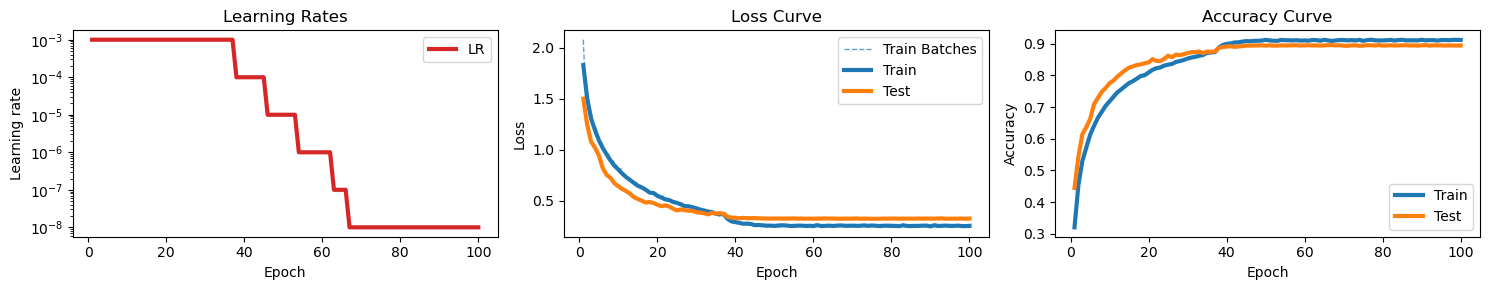

In [113]:
trainer.train(epochs=38, use_gpu=USE_GPU)
trainer.plot()

## Experiment

In [ ]:
class Model2(nn.Module):

  def __init__(self, channels, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
    super(Model2, self).__init__()
	
    self.debug=debug
    
    self.convs = nn.ModuleList(
        nn.Sequential(
            nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size),
            #nn.BatchNorm2d(num_features=channels[i+1]),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
        )
        for i in range(n)
    )
    self.img_sizes = find_img_size(initial_img_size=IMG_DIM, depth=n+1, kernel_size=kernel_size, stride=1, pool=2)
    print(f"{self.img_sizes=}")
    
    #self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.linear = nn.Sequential(
        nn.Linear(in_features=channels[-1], out_features=len(CLASSES), bias=False),
    )

  def set_debug(self, debug=True):
    self.debug = debug

  def forward(self, x):

    #x = self.conv1(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv2(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv3(x)
    #if self.debug: print(f"M: {x.shape=}")
    
    for conv in self.convs:
        x = conv(x)
        if self.debug: print(f"M conv: {x.shape=}")
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out